### Capstone 1: White Wine Quality, UC Irvine
(Source: Paulo Cortez (Univ. Minho), Antonio Cerdeira, Fernando Almeida, Telmo Matos and Jose Reis (CVRVV) @ 2009)

# 2. Linear Regression

### Outliers Removed, Categories Not Balanced

#### Audrey Hughes Rager
#### March 3, 2021


## Import Packages

In [167]:
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import datetime as dt
import statsmodels.api as sm
from scipy.stats import norm
import statsmodels.stats.weightstats as smsw
import pylab

# Import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
#from sklearn import cross_validation
from scipy import stats as st
import warnings 
warnings.filterwarnings('ignore')

#Import Imbalanced Learn
from imblearn.over_sampling import RandomOverSampler

# Import pyplot from matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('whitegrid')


<h2>Data Wrangling</h2>

In [168]:
#Import csv files into Pandas data frames
#reddf = pd.read_csv('winequality-red.csv',sep=";")
#whitedf = pd.read_csv('winequality-white.csv',sep=";")
df = pd.read_csv('winequality-white-outliers-removed.csv',sep=";")
df = df.rename({'fixed acidity': 'fixed_acidity','volatile acidity': 'volatile_acidity', 'citric acid': 'citric_acid', 'residual sugar':'residual_sugar',  'free sulfur dioxide':'free_sulfur_dioxide', 'total sulfur dioxide':'total_sulfur_dioxide'}, axis=1)

df.describe()


,Unnamed: 0,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000,3951.000000
mean,2509.315363,6.809048,0.263828,0.322749,6.352759,0.042299,34.730575,136.953176,0.993844,3.189043,0.481445,10.592035,5.953936
std,1414.165983,0.726417,0.076298,0.083076,4.905477,0.009889,14.941739,41.049024,0.002877,0.137980,0.098904,1.214421,0.856194
min,0.000000,4.900000,0.080000,0.110000,0.600000,0.016000,2.000000,19.000000,0.987110,2.830000,0.220000,8.400000,3.000000
25%,1269.000000,6.300000,0.210000,0.270000,1.800000,0.035000,24.000000,107.000000,0.991580,3.100000,0.410000,9.500000,5.000000
50%,2588.000000,6.800000,0.260000,0.310000,5.200000,0.042000,34.000000,132.000000,0.993520,3.180000,0.470000,10.500000,6.000000
75%,3731.500000,7.300000,0.310000,0.370000,9.600000,0.049000,45.000000,166.000000,0.995870,3.280000,0.540000,11.400000,6.000000
max,4897.000000,8.700000,0.485000,0.540000,20.800000,0.071000,78.000000,253.000000,1.001960,3.570000,0.760000,14.200000,9.000000


<h2>Identifying and Removing Outliers</h2>
<p>A predictor variable is considered to be an outlier only if it is > Q<sub>3</sub> + 1.5 IQR. Because all skewed data are positively skewed, we only need to eliminate those values.</p>

In [169]:
# Filtering Values between Q1-1.5IQR and Q3+1.5IQR
ValueList = ('fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides',
            'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol')

for myValue in ValueList:
    #compute range of data
    myValueMax = df[myValue].max()
    myValueMin = df[myValue].min()
    myValueRange = myValueMax - myValueMin
    
    # Computing IQR
    Q1 = df[myValue].quantile(0.25)
    Q3 = df[myValue].quantile(0.75)
    IQR = Q3 - Q1
    gtdropvalue = (Q3 + (1.5 * IQR))
    ltdropvalue = (Q1 - (1.5 * IQR))
    
    index_names_right = df[df[myValue] >= gtdropvalue].index
    index_names_left = df[df[myValue] <= ltdropvalue].index
    df.drop(index_names_right, inplace = True)
    df.drop(index_names_left, inplace = True)
    
    
   

In [170]:
df.describe()

,Unnamed: 0,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,3759.000000,3759.000000,3759.000000,3759.000000,3759.000000,3759.000000,3759.000000,3759.000000,3759.000000,3759.000000,3759.000000,3759.000000,3759.000000
mean,2506.943336,6.809936,0.261729,0.320564,6.344227,0.042298,34.605347,136.577946,0.993824,3.188606,0.477667,10.599330,5.959564
std,1413.814206,0.723280,0.073239,0.079510,4.904316,0.009842,14.713299,40.783830,0.002862,0.136200,0.094768,1.210461,0.849483
min,0.000000,4.900000,0.080000,0.130000,0.600000,0.016000,2.000000,21.000000,0.987110,2.840000,0.220000,8.400000,3.000000
25%,1272.500000,6.300000,0.210000,0.270000,1.800000,0.035000,24.000000,107.000000,0.991565,3.100000,0.410000,9.500000,5.000000
50%,2588.000000,6.800000,0.260000,0.310000,5.200000,0.042000,34.000000,132.000000,0.993500,3.180000,0.470000,10.500000,6.000000
75%,3723.500000,7.300000,0.310000,0.370000,9.575000,0.049000,45.000000,165.000000,0.995810,3.280000,0.540000,11.400000,6.000000
max,4897.000000,8.700000,0.450000,0.510000,20.800000,0.069000,76.000000,251.000000,1.001960,3.540000,0.730000,14.200000,9.000000


### Fitting Linear Regression using `statsmodels`
***
[Statsmodels](http://statsmodels.sourceforge.net/) is a great Python library for a lot of basic and inferential statistics. It also provides basic regression functions using an R-like syntax, so it's commonly used by statisticians. While we don't cover statsmodels officially in the Data Science Intensive workshop, it's a good library to have in your toolbox. Here's a quick example of what you could do with it. The version of least-squares we will use in statsmodels is called *ordinary least-squares (OLS)*. There are many other versions of least-squares such as [partial least squares (PLS)](https://en.wikipedia.org/wiki/Partial_least_squares_regression) and [weighted least squares (WLS)](https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares).

In [171]:
# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [172]:
sm.__version__

'0.12.0'

## Model 1


In [173]:
ym1 = df.quality
Xm1 = df.drop(['quality'],axis=1)
from sklearn.model_selection import train_test_split
Xm1_train, Xm1_test, ym1_train, ym1_test = train_test_split(Xm1, ym1, test_size=0.25, random_state=101)
Xm1_train.head()

,Unnamed: 0,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
1341,1757,6.9,0.29,0.23,8.6,0.056,56.0,215.0,0.99670,3.17,0.44,8.8
1062,1377,6.9,0.28,0.41,1.7,0.050,10.0,136.0,0.99300,3.16,0.71,11.4
2971,3743,7.0,0.15,0.28,14.7,0.051,29.0,149.0,0.99792,2.96,0.39,9.0
2151,2799,6.7,0.16,0.37,1.3,0.036,45.0,125.0,0.98964,3.19,0.51,12.4
405,518,5.9,0.13,0.28,1.9,0.050,20.0,78.0,0.99180,3.43,0.64,10.8


In [174]:
Xm1_train.shape

(2819, 12)

In [175]:
from sklearn.linear_model import LinearRegression
lm1 = LinearRegression()
lm1.fit(Xm1_train,ym1_train)
print('Estimated intercept coefficient:',lm1.intercept_)
print ('Number of coefficients:', len(lm1.coef_))
coeffm1_df = pd.DataFrame(lm1.coef_,Xm1.columns,columns=['Coefficient'])
coeffm1_df

Estimated intercept coefficient: 228.26083426575047
Number of coefficients: 12


,Coefficient
Unnamed: 0,-0.000056
fixed_acidity,0.150635
volatile_acidity,-1.927559
citric_acid,-0.191932
residual_sugar,0.107831
chlorides,-3.311658
free_sulfur_dioxide,0.004781
total_sulfur_dioxide,0.000246
density,-228.343715
pH,0.696375


In [176]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#find design matrix for linear regression model using 'rating' as response variable 
ym1, Xm1 = dmatrices('quality ~ fixed_acidity+volatile_acidity+citric_acid+residual_sugar+chlorides+free_sulfur_dioxide+total_sulfur_dioxide+density+pH+sulphates+alcohol', data=df, return_type='dataframe')

#calculate VIF for each explanatory variable
vifm1 = pd.DataFrame()
vifm1['VIF'] = [variance_inflation_factor(Xm1.values, i) for i in range(Xm1.shape[1])]
vifm1['variable'] = Xm1.columns

#view VIF for each explanatory variable 
vifm1

,VIF,variable
0,5.594502e+06,Intercept
1,2.922610e+00,fixed_acidity
2,1.150645e+00,volatile_acidity
3,1.122511e+00,citric_acid
4,1.875046e+01,residual_sugar
5,1.562118e+00,chlorides
6,1.826980e+00,free_sulfur_dioxide
7,2.476600e+00,total_sulfur_dioxide
8,4.703059e+01,density
9,2.314887e+00,pH


In [177]:
predictions_m1 = lm1.predict(Xm1_test)

**Predicted vs. Actual**

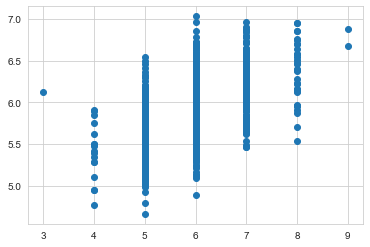

In [178]:
plt.scatter(ym1_test,predictions_m1)

**Residual Histogram**

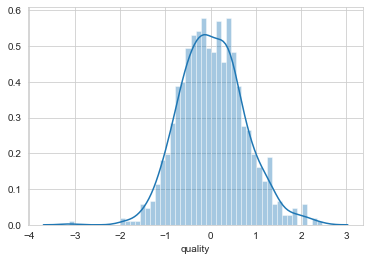

In [179]:
sns.distplot((ym1_test-predictions_m1),bins=50);

In [180]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym1_test, predictions_m1))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym1_test, predictions_m1))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym1_test, predictions_m1)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym1_test, predictions_m1))
print('Explained Variance:', metrics.explained_variance_score(ym1_test, predictions_m1))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym1_test, predictions_m1))
print('Median Absolute Error:', metrics.median_absolute_error(ym1_test, predictions_m1))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym1_test, predictions_m1))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym1_test, predictions_m1))



R-squared: 0.29505462716995956
Mean Squared Error (MSE): 0.5087119090136746
Root Mean Squared Error (RMSE): 0.7132404286169388
Log Mean Squared Error: 0.010529962876107527
Explained Variance: 0.29704449601147653
Mean Absolute Error (MAE): 0.5650602444170763
Median Absolute Error: 0.47303145555838455
Poisson Deviance: 0.08496022918428513
Mean Gamma Deviance: 0.014386823969237447


## Model 2 -  Drop Density For High VIF

In [181]:
ym2 = df.quality
Xm2 = df.drop(['quality','density'],axis=1)
from sklearn.model_selection import train_test_split
Xm2_train, Xm2_test, ym2_train, ym2_test = train_test_split(Xm2, ym2, test_size=0.25, random_state=101)
Xm2_train.head()

,Unnamed: 0,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,pH,sulphates,alcohol
1341,1757,6.9,0.29,0.23,8.6,0.056,56.0,215.0,3.17,0.44,8.8
1062,1377,6.9,0.28,0.41,1.7,0.050,10.0,136.0,3.16,0.71,11.4
2971,3743,7.0,0.15,0.28,14.7,0.051,29.0,149.0,2.96,0.39,9.0
2151,2799,6.7,0.16,0.37,1.3,0.036,45.0,125.0,3.19,0.51,12.4
405,518,5.9,0.13,0.28,1.9,0.050,20.0,78.0,3.43,0.64,10.8


In [182]:
from sklearn.linear_model import LinearRegression
lm2 = LinearRegression()
lm2.fit(Xm2_train,ym2_train)
print('Estimated intercept coefficient:',lm2.intercept_)
print ('Number of coefficients:', len(lm2.coef_))
coeffm2_df = pd.DataFrame(lm2.coef_,Xm2.columns,columns=['Coefficient'])
coeffm2_df

Estimated intercept coefficient: 2.9106650463893535
Number of coefficients: 11


,Coefficient
Unnamed: 0,-0.000053
fixed_acidity,-0.016631
volatile_acidity,-1.982527
citric_acid,-0.286405
residual_sugar,0.026705
chlorides,-5.716798
free_sulfur_dioxide,0.006291
total_sulfur_dioxide,-0.000680
pH,-0.018560
sulphates,0.534802


In [183]:
predictions_m2 = lm2.predict(Xm2_test)

**Predicted vs. Actual**

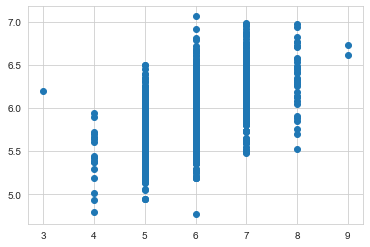

In [184]:
plt.scatter(ym2_test,predictions_m2)

**Residual Histogram**

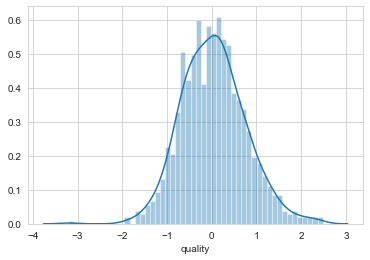

In [185]:
sns.distplot((ym2_test-predictions_m2),bins=50);

In [186]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym2_test, predictions_m2))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym2_test, predictions_m2))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym2_test, predictions_m2)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym2_test, predictions_m2))
print('Explained Variance:', metrics.explained_variance_score(ym2_test, predictions_m2))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym2_test, predictions_m2))
print('Median Absolute Error:', metrics.median_absolute_error(ym2_test, predictions_m2))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym2_test, predictions_m2))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym2_test, predictions_m2))



R-squared: 0.29275609418185944
Mean Squared Error (MSE): 0.510370606480704
Root Mean Squared Error (RMSE): 0.7144022721693317
Log Mean Squared Error: 0.0105406681967557
Explained Variance: 0.2947166432973174
Mean Absolute Error (MAE): 0.5613576222220323
Median Absolute Error: 0.46681675309790105
Poisson Deviance: 0.08513743755033043
Mean Gamma Deviance: 0.014400691106912871


In [187]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#find design matrix for linear regression model using 'rating' as response variable 
ym2, Xm2 = dmatrices('quality ~ fixed_acidity+volatile_acidity+citric_acid+residual_sugar+chlorides+free_sulfur_dioxide+total_sulfur_dioxide+pH+sulphates+alcohol', data=df, return_type='dataframe')

#calculate VIF for each explanatory variable
vifm2 = pd.DataFrame()
vifm2['VIF'] = [variance_inflation_factor(Xm2.values, i) for i in range(Xm2.shape[1])]
vifm2['variable'] = Xm2.columns

#view VIF for each explanatory variable 
vifm2

,VIF,variable
0,1230.869516,Intercept
1,1.277560,fixed_acidity
2,1.148697,volatile_acidity
3,1.116169,citric_acid
4,1.525892,residual_sugar
5,1.504576,chlorides
6,1.765687,free_sulfur_dioxide
7,2.297958,total_sulfur_dioxide
8,1.241939,pH
9,1.053502,sulphates


## Backward Elimination Method to create subsequent models

## Model 3: Drop Total Sulfur Dioxide


In [188]:
ym3 = df.quality
Xm3 = df.drop(['quality','density','total_sulfur_dioxide'],axis=1)
from sklearn.model_selection import train_test_split
Xm3_train, Xm3_test, ym3_train, ym3_test = train_test_split(Xm3, ym3, test_size=0.25, random_state=101)
Xm3_train.head()

,Unnamed: 0,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,pH,sulphates,alcohol
1341,1757,6.9,0.29,0.23,8.6,0.056,56.0,3.17,0.44,8.8
1062,1377,6.9,0.28,0.41,1.7,0.050,10.0,3.16,0.71,11.4
2971,3743,7.0,0.15,0.28,14.7,0.051,29.0,2.96,0.39,9.0
2151,2799,6.7,0.16,0.37,1.3,0.036,45.0,3.19,0.51,12.4
405,518,5.9,0.13,0.28,1.9,0.050,20.0,3.43,0.64,10.8


In [189]:
Xm3_train.shape

(2819, 10)

In [190]:
from sklearn.linear_model import LinearRegression
lm3 = LinearRegression()
lm3.fit(Xm3_train,ym3_train)
print('Estimated intercept coefficient:',lm3.intercept_)
print ('Number of coefficients:', len(lm3.coef_))
coeffm1_df = pd.DataFrame(lm3.coef_,Xm3.columns,columns=['Coefficient'])
coeffm1_df

Estimated intercept coefficient: 2.9074324486431777
Number of coefficients: 10


,Coefficient
Unnamed: 0,-0.000051
fixed_acidity,-0.018984
volatile_acidity,-2.053721
citric_acid,-0.303514
residual_sugar,0.026204
chlorides,-6.099506
free_sulfur_dioxide,0.005333
pH,-0.032477
sulphates,0.512477
alcohol,0.349189


In [191]:
predictions_m3 = lm3.predict(Xm3_test)

**Predicted vs. Actual**

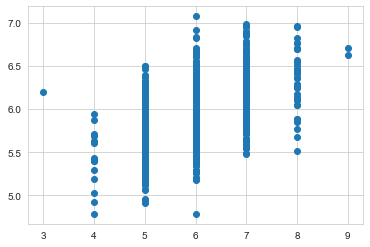

In [192]:
plt.scatter(ym3_test,predictions_m3)

**Residual Histogram**

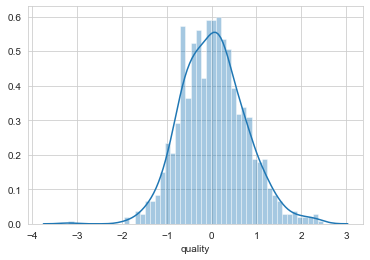

In [193]:
sns.distplot((ym3_test-predictions_m3),bins=50);

In [194]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym3_test, predictions_m3))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym3_test, predictions_m3))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym3_test, predictions_m3)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym3_test, predictions_m3))
print('Explained Variance:', metrics.explained_variance_score(ym3_test, predictions_m3))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym3_test, predictions_m3))
print('Median Absolute Error:', metrics.median_absolute_error(ym3_test, predictions_m3))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym3_test, predictions_m3))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym3_test, predictions_m3))



R-squared: 0.2899037198200475
Mean Squared Error (MSE): 0.5124289742106655
Root Mean Squared Error (RMSE): 0.7158414448819413
Log Mean Squared Error: 0.010579159069754547
Explained Variance: 0.29193778694344297
Mean Absolute Error (MAE): 0.5625406124015764
Median Absolute Error: 0.46557422040717134
Poisson Deviance: 0.08547120812386733
Mean Gamma Deviance: 0.01445488283564664


## Model 4: Drop Free Sulfur Dioxide

In [195]:
ym4 = df.quality
Xm4 = df.drop(['quality','density','total_sulfur_dioxide','free_sulfur_dioxide'],axis=1)
from sklearn.model_selection import train_test_split
Xm4_train, Xm4_test, ym4_train, ym4_test = train_test_split(Xm4, ym4, test_size=0.25, random_state=101)
Xm4_train.head()


,Unnamed: 0,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,pH,sulphates,alcohol
1341,1757,6.9,0.29,0.23,8.6,0.056,3.17,0.44,8.8
1062,1377,6.9,0.28,0.41,1.7,0.050,3.16,0.71,11.4
2971,3743,7.0,0.15,0.28,14.7,0.051,2.96,0.39,9.0
2151,2799,6.7,0.16,0.37,1.3,0.036,3.19,0.51,12.4
405,518,5.9,0.13,0.28,1.9,0.050,3.43,0.64,10.8


In [196]:
Xm4_train.shape

(2819, 9)

In [197]:
lm4 = LinearRegression()
lm4.fit(Xm4_train,ym4_train)
print('Estimated intercept coefficient:',lm4.intercept_)
print ('Number of coefficients:', len(lm4.coef_))
coeffm4_df = pd.DataFrame(lm4.coef_,Xm4.columns,columns=['Coefficient'])
coeffm4_df

Estimated intercept coefficient: 3.1333608124900283
Number of coefficients: 9


,Coefficient
Unnamed: 0,-0.000051
fixed_acidity,-0.028114
volatile_acidity,-2.092227
citric_acid,-0.221737
residual_sugar,0.030827
chlorides,-5.879523
pH,-0.023800
sulphates,0.523843
alcohol,0.342724


In [198]:
predictions_m4 = lm4.predict(Xm4_test)

**Predicted vs. Actual**

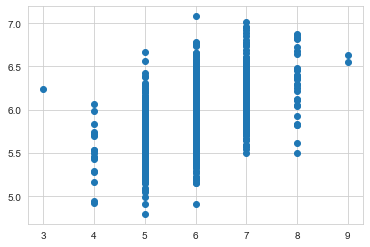

In [199]:
plt.scatter(ym1_test,predictions_m4)

**Residual Histogram**

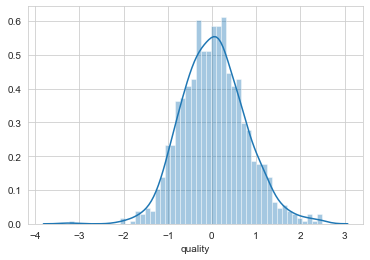

In [200]:
sns.distplot((ym4_test-predictions_m4),bins=50);

## Model 5: Drop Fixed Acidity


In [201]:
ym5 = df.quality
Xm5 = df.drop(['quality','density','total_sulfur_dioxide','free_sulfur_dioxide','fixed_acidity'],axis=1)
from sklearn.model_selection import train_test_split
Xm5_train, Xm5_test, ym5_train, ym5_test = train_test_split(Xm5, ym5, test_size=0.25, random_state=101)
Xm5_train.head()




,Unnamed: 0,volatile_acidity,citric_acid,residual_sugar,chlorides,pH,sulphates,alcohol
1341,1757,0.29,0.23,8.6,0.056,3.17,0.44,8.8
1062,1377,0.28,0.41,1.7,0.050,3.16,0.71,11.4
2971,3743,0.15,0.28,14.7,0.051,2.96,0.39,9.0
2151,2799,0.16,0.37,1.3,0.036,3.19,0.51,12.4
405,518,0.13,0.28,1.9,0.050,3.43,0.64,10.8


In [202]:
Xm5_train.shape

(2819, 8)

In [203]:
from sklearn.linear_model import LinearRegression
lm5 = LinearRegression()
lm5.fit(Xm5_train,ym5_train)
print('Estimated intercept coefficient:',lm5.intercept_)
print ('Number of coefficients:', len(lm5.coef_))
coeffm5_df = pd.DataFrame(lm5.coef_,Xm5.columns,columns=['Coefficient'])
coeffm5_df

Estimated intercept coefficient: 2.7704926556997806
Number of coefficients: 8


,Coefficient
Unnamed: 0,-0.000047
volatile_acidity,-2.085176
citric_acid,-0.264021
residual_sugar,0.030885
chlorides,-6.152070
pH,0.038155
sulphates,0.519268
alcohol,0.341570


In [204]:
predictions_m5 = lm5.predict(Xm5_test)

**Predicted vs. Actual**

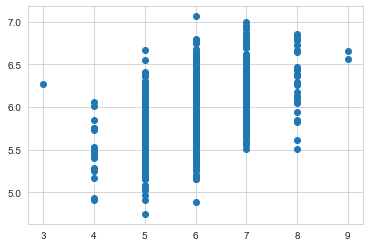

In [205]:
plt.scatter(ym5_test,predictions_m5)

**Residual Histogram**

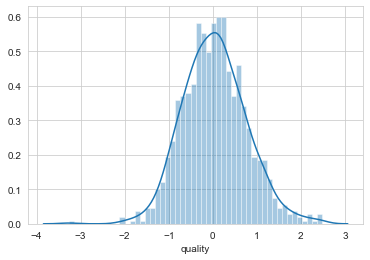

In [206]:
sns.distplot((ym5_test-predictions_m5),bins=50);

In [207]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym5_test, predictions_m5))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym5_test, predictions_m5))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym5_test, predictions_m5)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym5_test, predictions_m5))
print('Explained Variance:', metrics.explained_variance_score(ym5_test, predictions_m5))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym5_test, predictions_m5))
print('Median Absolute Error:', metrics.median_absolute_error(ym5_test, predictions_m5))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym5_test, predictions_m5))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym5_test, predictions_m5))



R-squared: 0.27749714043233753
Mean Squared Error (MSE): 0.5213819724540815
Root Mean Squared Error (RMSE): 0.7220678447722773
Log Mean Squared Error: 0.01076779814530553
Explained Variance: 0.28004412262398903
Mean Absolute Error (MAE): 0.5659139146623344
Median Absolute Error: 0.4802697462702863
Poisson Deviance: 0.08692972660153361
Mean Gamma Deviance: 0.014693760026546081



## Model 6: Drop Residual Sugar



In [208]:
ym6 = df.quality
Xm6 = df.drop(['quality','density','total_sulfur_dioxide','free_sulfur_dioxide','fixed_acidity','residual_sugar'],axis=1)
from sklearn.model_selection import train_test_split
Xm6_train, Xm6_test, ym6_train, ym6_test = train_test_split(Xm6, ym6, test_size=0.25, random_state=101)
Xm6_train.head()


,Unnamed: 0,volatile_acidity,citric_acid,chlorides,pH,sulphates,alcohol
1341,1757,0.29,0.23,0.056,3.17,0.44,8.8
1062,1377,0.28,0.41,0.050,3.16,0.71,11.4
2971,3743,0.15,0.28,0.051,2.96,0.39,9.0
2151,2799,0.16,0.37,0.036,3.19,0.51,12.4
405,518,0.13,0.28,0.050,3.43,0.64,10.8


In [209]:
Xm6_train.shape

(2819, 7)

In [210]:
from sklearn.linear_model import LinearRegression
lm6 = LinearRegression()
lm6.fit(Xm6_train,ym6_train)
print('Estimated intercept coefficient:',lm6.intercept_)
print ('Number of coefficients:', len(lm6.coef_))
coeffm6_df = pd.DataFrame(lm6.coef_,Xm6.columns,columns=['Coefficient'])
coeffm6_df


Estimated intercept coefficient: 4.065321955210803
Number of coefficients: 7


,Coefficient
Unnamed: 0,-0.000037
volatile_acidity,-1.824968
citric_acid,-0.238530
chlorides,-6.079687
pH,-0.106309
sulphates,0.396100
alcohol,0.277019


In [211]:
predictions_m6 = lm6.predict(Xm6_test)

**Predicted vs. Actual**

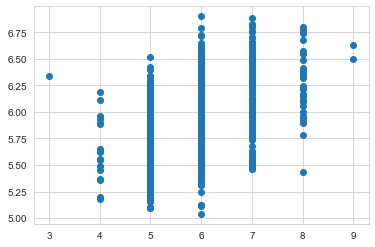

In [212]:
plt.scatter(ym6_test,predictions_m6)

**Residual Histogram**

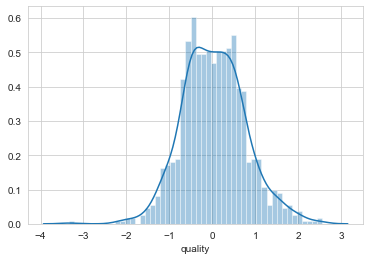

In [213]:
sns.distplot((ym6_test-predictions_m6),bins=50);

In [214]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym6_test, predictions_m6))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym6_test, predictions_m6))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym6_test, predictions_m6)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym6_test, predictions_m6))
print('Explained Variance:', metrics.explained_variance_score(ym6_test, predictions_m6))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym6_test, predictions_m6))
print('Median Absolute Error:', metrics.median_absolute_error(ym6_test, predictions_m6))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym6_test, predictions_m6))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym6_test, predictions_m6))



R-squared: 0.25054734063650796
Mean Squared Error (MSE): 0.5408298398067454
Root Mean Squared Error (RMSE): 0.7354113405480944
Log Mean Squared Error: 0.011217406420244705
Explained Variance: 0.25303244691512716
Mean Absolute Error (MAE): 0.5802636430505315
Median Absolute Error: 0.48813627604686394
Poisson Deviance: 0.09033156198434757
Mean Gamma Deviance: 0.015291635480847703


## Model 7: Drop Citric Acid

In [215]:
ym7 = df.quality
Xm7 = df.drop(['quality','density','total_sulfur_dioxide','free_sulfur_dioxide','fixed_acidity','residual_sugar','citric_acid'],axis=1)
from sklearn.model_selection import train_test_split
Xm7_train, Xm7_test, ym7_train, ym7_test = train_test_split(Xm7, ym7, test_size=0.25, random_state=101)
Xm7_train.head()


,Unnamed: 0,volatile_acidity,chlorides,pH,sulphates,alcohol
1341,1757,0.29,0.056,3.17,0.44,8.8
1062,1377,0.28,0.050,3.16,0.71,11.4
2971,3743,0.15,0.051,2.96,0.39,9.0
2151,2799,0.16,0.036,3.19,0.51,12.4
405,518,0.13,0.050,3.43,0.64,10.8


In [216]:
Xm7_train.shape

(2819, 6)

In [217]:
from sklearn.linear_model import LinearRegression
lm7 = LinearRegression()
lm7.fit(Xm7_train,ym7_train)
print('Estimated intercept coefficient:',lm7.intercept_)
print ('Number of coefficients:', len(lm7.coef_))
coeffm7_df = pd.DataFrame(lm7.coef_,Xm7.columns,columns=['Coefficient'])
coeffm7_df

Estimated intercept coefficient: 3.9431712907824057
Number of coefficients: 6


,Coefficient
Unnamed: 0,-0.000033
volatile_acidity,-1.791862
chlorides,-6.180124
pH,-0.086526
sulphates,0.377847
alcohol,0.275017


In [218]:
predictions_m7 = lm7.predict(Xm7_test)

**Predicted vs. Actual**

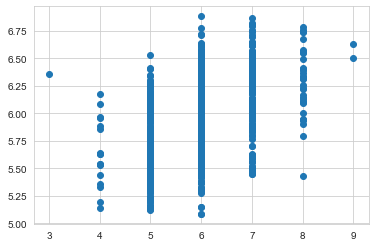

In [219]:
plt.scatter(ym7_test,predictions_m7)

**Residual Histogram**

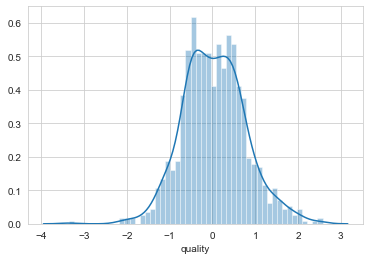

In [220]:
sns.distplot((ym7_test-predictions_m7),bins=50);

In [221]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym7_test, predictions_m7))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym7_test, predictions_m7))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym7_test, predictions_m7)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym7_test, predictions_m7))
print('Explained Variance:', metrics.explained_variance_score(ym7_test, predictions_m7))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym7_test, predictions_m7))
print('Median Absolute Error:', metrics.median_absolute_error(ym7_test, predictions_m7))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym7_test, predictions_m7))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym7_test, predictions_m7))


R-squared: 0.2515452464614665
Mean Squared Error (MSE): 0.5401097179408587
Root Mean Squared Error (RMSE): 0.7349215726462646
Log Mean Squared Error: 0.01119636658773741
Explained Variance: 0.2542025232169174
Mean Absolute Error (MAE): 0.5809097085041185
Median Absolute Error: 0.4913905923486981
Poisson Deviance: 0.09019013285233325
Mean Gamma Deviance: 0.015264310357764687


## Model 8: Drop Alcohol

In [222]:
ym8 = df.quality
Xm8 = df.drop(['quality','density','total_sulfur_dioxide','free_sulfur_dioxide','fixed_acidity','residual_sugar','citric_acid','alcohol'],axis=1)
from sklearn.model_selection import train_test_split
Xm8_train, Xm8_test, ym8_train, ym8_test = train_test_split(Xm8, ym8, test_size=0.25, random_state=101)
Xm8_train.head()

,Unnamed: 0,volatile_acidity,chlorides,pH,sulphates
1341,1757,0.29,0.056,3.17,0.44
1062,1377,0.28,0.050,3.16,0.71
2971,3743,0.15,0.051,2.96,0.39
2151,2799,0.16,0.036,3.19,0.51
405,518,0.13,0.050,3.43,0.64


In [223]:
Xm8_train.shape

(2819, 5)

In [224]:
from sklearn.linear_model import LinearRegression
lm8 = LinearRegression()
lm8.fit(Xm8_train,ym8_train)
print('Estimated intercept coefficient:',lm8.intercept_)
print ('Number of coefficients:', len(lm8.coef_))
coeffm8_df = pd.DataFrame(lm8.coef_,Xm8.columns,columns=['Coefficient'])
coeffm8_df

Estimated intercept coefficient: 6.809764298797286
Number of coefficients: 5


,Coefficient
Unnamed: 0,0.000009
volatile_acidity,-1.345625
chlorides,-24.676797
pH,0.139188
sulphates,0.149874


In [225]:
predictions_m8 = lm8.predict(Xm8_test)

**Predicted vs. Actual**

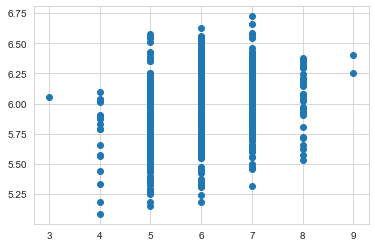

In [226]:
plt.scatter(ym8_test,predictions_m8)

**Residual Histogram**

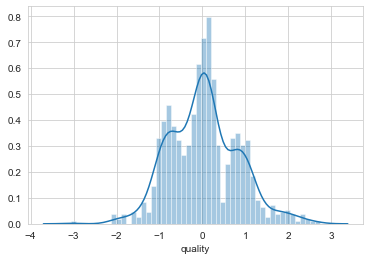

In [227]:
sns.distplot((ym8_test-predictions_m8),bins=50);

In [228]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym8_test, predictions_m8))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym8_test, predictions_m8))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym8_test, predictions_m8)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym8_test, predictions_m8))
print('Explained Variance:', metrics.explained_variance_score(ym8_test, predictions_m8))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym8_test, predictions_m8))
print('Median Absolute Error:', metrics.median_absolute_error(ym8_test, predictions_m8))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym8_test, predictions_m8))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym8_test, predictions_m8))


R-squared: 0.10829112063496027
Mean Squared Error (MSE): 0.6434866356880116
Root Mean Squared Error (RMSE): 0.8021761874351616
Log Mean Squared Error: 0.013263668114670711
Explained Variance: 0.10985076104949143
Mean Absolute Error (MAE): 0.6205641127448548
Median Absolute Error: 0.5639280614495652
Poisson Deviance: 0.10736099700060933
Mean Gamma Deviance: 0.018123260125771538


## Model 9: Drop pH

In [229]:
ym9 = df.quality
Xm9 = df.drop(['quality','density','total_sulfur_dioxide','free_sulfur_dioxide','fixed_acidity','residual_sugar','citric_acid','alcohol','pH'],axis=1)
from sklearn.model_selection import train_test_split
Xm9_train, Xm9_test, ym9_train, ym9_test = train_test_split(Xm9, ym9, test_size=0.25, random_state=101)
Xm9_train.head()


,Unnamed: 0,volatile_acidity,chlorides,sulphates
1341,1757,0.29,0.056,0.44
1062,1377,0.28,0.050,0.71
2971,3743,0.15,0.051,0.39
2151,2799,0.16,0.036,0.51
405,518,0.13,0.050,0.64


In [230]:
Xm9_train.shape

(2819, 4)

In [231]:
from sklearn.linear_model import LinearRegression
lm9 = LinearRegression()
lm9.fit(Xm9_train,ym9_train)
print('Estimated intercept coefficient:',lm9.intercept_)
print ('Number of coefficients:', len(lm9.coef_))
coeffm9_df = pd.DataFrame(lm9.coef_,Xm9.columns,columns=['Coefficient'])
coeffm9_df


Estimated intercept coefficient: 7.249649281406007
Number of coefficients: 4


,Coefficient
Unnamed: 0,0.000007
volatile_acidity,-1.347141
chlorides,-24.776594
sulphates,0.179651


In [232]:
predictions_m9 = lm9.predict(Xm9_test)

**Predicted vs. Actual**

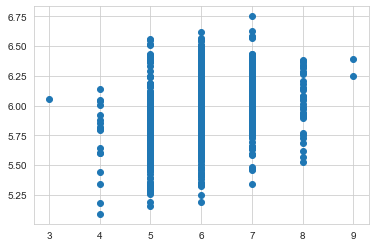

In [233]:
plt.scatter(ym9_test,predictions_m9)

**Residual Histogram**

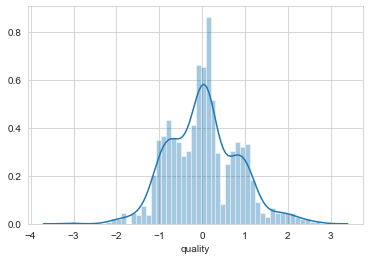

In [234]:
sns.distplot((ym9_test-predictions_m9),bins=50);

In [235]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym9_test, predictions_m9))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym9_test, predictions_m9))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym9_test, predictions_m9)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym9_test, predictions_m9))
print('Explained Variance:', metrics.explained_variance_score(ym9_test, predictions_m9))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym9_test, predictions_m9))
print('Median Absolute Error:', metrics.median_absolute_error(ym9_test, predictions_m9))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym9_test, predictions_m9))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym9_test, predictions_m9))


R-squared: 0.10545973440549339
Mean Squared Error (MSE): 0.6455298576871358
Root Mean Squared Error (RMSE): 0.8034487274786959
Log Mean Squared Error: 0.013305887610284233
Explained Variance: 0.10697759342731639
Mean Absolute Error (MAE): 0.6215894578679947
Median Absolute Error: 0.5646640425382214
Poisson Deviance: 0.10769761214283147
Mean Gamma Deviance: 0.018178670537460865


## Model 10: Drop Sulphates

In [236]:
ym10 = df.quality
Xm10 = df.drop(['quality','density','total_sulfur_dioxide','free_sulfur_dioxide','fixed_acidity','residual_sugar','citric_acid','alcohol','pH','sulphates'],axis=1)
from sklearn.model_selection import train_test_split
Xm10_train, Xm10_test, ym10_train, ym10_test = train_test_split(Xm10, ym10, test_size=0.25, random_state=101)
Xm10_train.head()


,Unnamed: 0,volatile_acidity,chlorides
1341,1757,0.29,0.056
1062,1377,0.28,0.050
2971,3743,0.15,0.051
2151,2799,0.16,0.036
405,518,0.13,0.050


In [237]:
Xm10_train.shape

(2819, 3)

In [238]:
from sklearn.linear_model import LinearRegression
lm10 = LinearRegression()
lm10.fit(Xm10_train,ym10_train)
print('Estimated intercept coefficient:',lm10.intercept_)
print ('Number of coefficients:', len(lm10.coef_))
coeffm10_df = pd.DataFrame(lm10.coef_,Xm10.columns,columns=['Coefficient'])
coeffm10_df

Estimated intercept coefficient: 7.329521994906569
Number of coefficients: 3


,Coefficient
Unnamed: 0,0.000007
volatile_acidity,-1.343875
chlorides,-24.662220


In [239]:
predictions_m10 = lm10.predict(Xm10_test)

**Predicted vs. Actual**

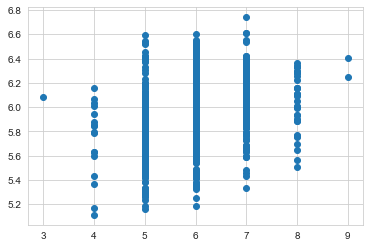

In [240]:
plt.scatter(ym10_test,predictions_m10)

**Residual Histogram**

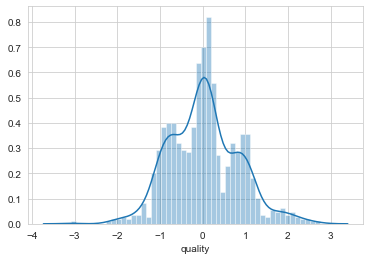

In [241]:
sns.distplot((ym10_test-predictions_m10),bins=50);

In [242]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym10_test, predictions_m10))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym10_test, predictions_m10))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym10_test, predictions_m10)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym10_test, predictions_m10))
print('Explained Variance:', metrics.explained_variance_score(ym10_test, predictions_m10))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym10_test, predictions_m10))
print('Median Absolute Error:', metrics.median_absolute_error(ym10_test, predictions_m10))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym10_test, predictions_m10))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym10_test, predictions_m10))


R-squared: 0.10310630618999517
Mean Squared Error (MSE): 0.6472281693668429
Root Mean Squared Error (RMSE): 0.8045049219034294
Log Mean Squared Error: 0.013341107998232526
Explained Variance: 0.10469528831618968
Mean Absolute Error (MAE): 0.6220087759114465
Median Absolute Error: 0.5664883657597999
Poisson Deviance: 0.10796715364029924
Mean Gamma Deviance: 0.018221438144960442


## Model 11: Drop Volatile Activity

In [243]:
ym11 = df.quality
Xm11 = df.drop(['quality','density','total_sulfur_dioxide','free_sulfur_dioxide','fixed_acidity','residual_sugar','citric_acid','alcohol','pH','sulphates','volatile_acidity'],axis=1)
from sklearn.model_selection import train_test_split
Xm11_train, Xm11_test, ym11_train, ym11_test = train_test_split(Xm11, ym11, test_size=0.25, random_state=101)
Xm11_train.head()


,Unnamed: 0,chlorides
1341,1757,0.056
1062,1377,0.050
2971,3743,0.051
2151,2799,0.036
405,518,0.050


In [244]:
Xm11_train.shape

(2819, 2)

In [245]:
from sklearn.linear_model import LinearRegression
lm11 = LinearRegression()
lm11.fit(Xm11_train,ym11_train)
print('Estimated intercept coefficient:',lm11.intercept_)
print ('Number of coefficients:', len(lm11.coef_))
coeffm11_df = pd.DataFrame(lm11.coef_,Xm11.columns,columns=['Coefficient'])
coeffm11_df

Estimated intercept coefficient: 6.96429922551326
Number of coefficients: 2


,Coefficient
Unnamed: 0,0.000004
chlorides,-24.139864


In [246]:
predictions_m11 = lm11.predict(Xm11_test)

**Predicted vs. Actual**

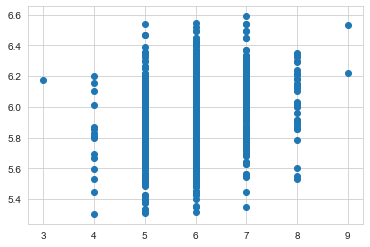

In [247]:
plt.scatter(ym11_test,predictions_m11)

**Residual Histogram**

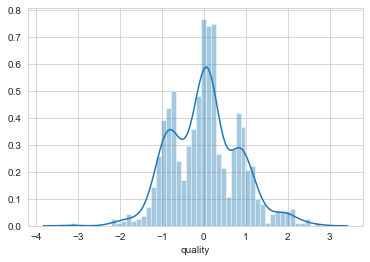

In [248]:
sns.distplot((ym11_test-predictions_m11),bins=50);

In [249]:
from sklearn import metrics
print('R-squared:', metrics.r2_score(ym11_test, predictions_m11))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(ym11_test, predictions_m11))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(ym11_test, predictions_m11)))
print('Log Mean Squared Error:', metrics.mean_squared_log_error(ym11_test, predictions_m11))
print('Explained Variance:', metrics.explained_variance_score(ym11_test, predictions_m11))
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(ym11_test, predictions_m11))
print('Median Absolute Error:', metrics.median_absolute_error(ym11_test, predictions_m11))
print('Poisson Deviance:', metrics.mean_poisson_deviance(ym11_test, predictions_m11))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(ym11_test, predictions_m11))


R-squared: 0.08976090235374279
Mean Squared Error (MSE): 0.656858654399809
Root Mean Squared Error (RMSE): 0.8104681698868925
Log Mean Squared Error: 0.013600432684904106
Explained Variance: 0.09078676803634544
Mean Absolute Error (MAE): 0.6268176838337319
Median Absolute Error: 0.6030112900373239
Poisson Deviance: 0.10971114349909517
Mean Gamma Deviance: 0.018536431229161217
